**Import Libraries and data**

In [3]:
import pandas as pd
import logging
import os
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Try using ISO-8859-1 (Latin-1) encoding
df = pd.read_csv('/content/sample_data/twitter_disaster.csv', encoding='ISO-8859-1')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
print(df.shape)


(7613, 5)


In [5]:
print(df.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [6]:
print(df.tail())

         id keyword location  \
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  


In [7]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [8]:
print(df.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


**Checking for Missing values**

In [9]:
print(df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [10]:
# Fill missing keyword/location with placeholder
df['keyword'] = df['keyword'].fillna('no_keyword')
df['location'] = df['location'].fillna('no_location')

In [11]:
print(df.isnull().sum())

id          0
keyword     0
location    0
text        0
target      0
dtype: int64


**Visualize Class Distribution (Disaster vs. Non-Disaster Tweets)**

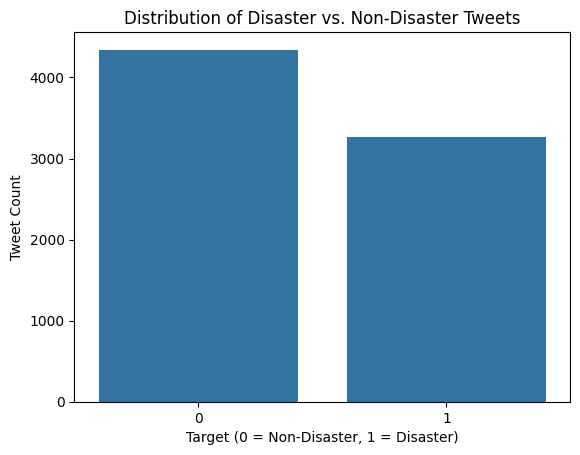


Percentage Distribution:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot
sns.countplot(x='target', data=df)
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Tweet Count')
plt.show()

# Print percentage distribution
percentages = df['target'].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
print(percentages)


**Analyze Frequent Keywords in Disaster Tweets**

1.Clean the text column 2.WordCloud of Disaster Tweets

In [13]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)        # remove punctuation and numbers
    return text

df['clean_text'] = df['text'].apply(clean_text)

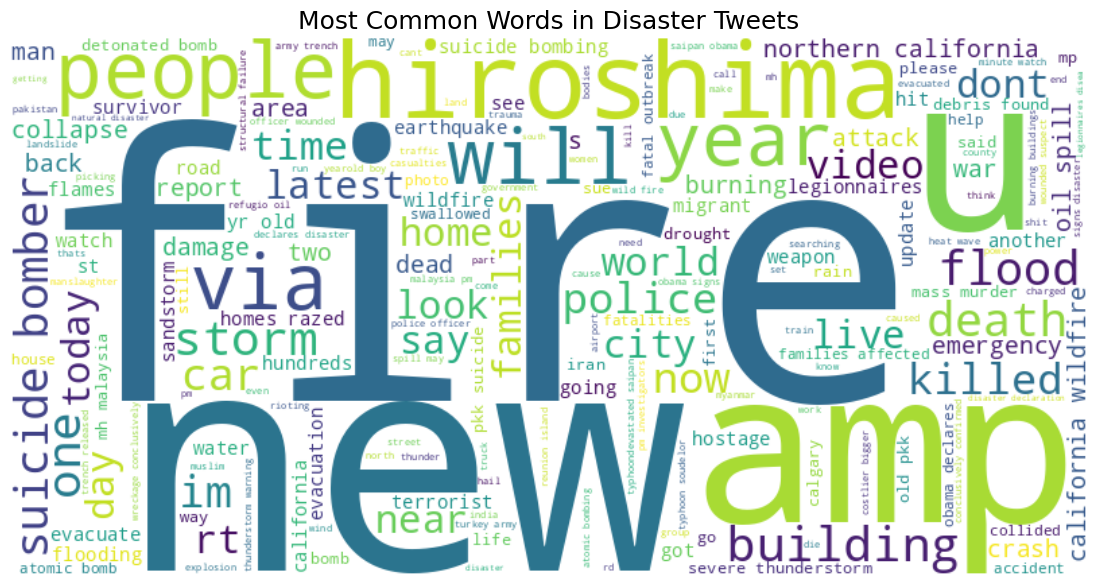

In [14]:
from wordcloud import WordCloud

# Filter disaster tweets
disaster_tweets = df[df['target'] == 1]['clean_text']

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(disaster_tweets))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Disaster Tweets", fontsize=18)
plt.show()

**Top 20 Frequent Words in Disaster Tweets**

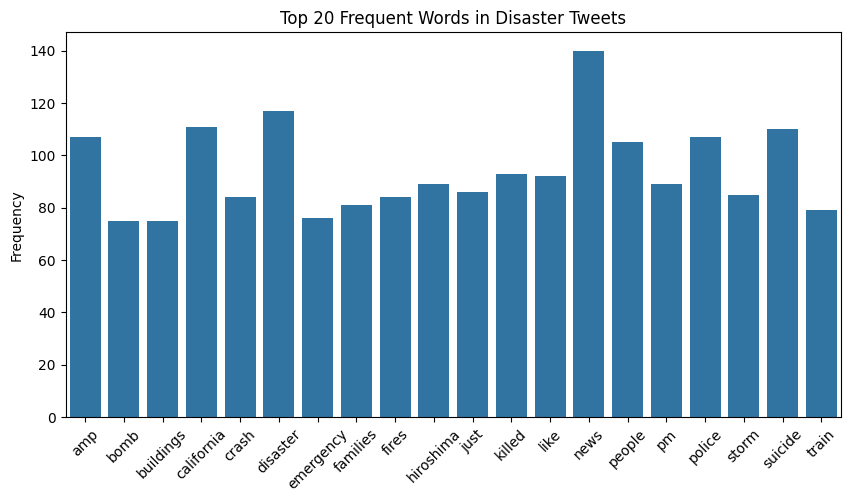

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(disaster_tweets)

# Sum frequencies
word_freq = X.toarray().sum(axis=0)
freq_dict = dict(zip(vectorizer.get_feature_names_out(), word_freq))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(freq_dict.keys()), y=list(freq_dict.values()))
plt.xticks(rotation=45)
plt.title("Top 20 Frequent Words in Disaster Tweets")
plt.ylabel("Frequency")
plt.show()

**Tokenize the Text**

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization setup
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])

# Convert to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Sample tokenized and padded sequence:\n", X[0])

Sample tokenized and padded sequence:
 [ 109 4353   22    2  820    6   19  240  126 1543 4354   67   39    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


**Convert Labels to Numeric**

In [17]:
y = df['target'].values

**Split the Dataset**

In [18]:
from sklearn.model_selection import train_test_split

# Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (6090, 100)
Testing set size: (1523, 100)


**Feature Engineering and Model Selection**
TF-IDF Features

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['clean_text'])

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (7613, 5000)



**Pretrained Word Embeddings (GloVe)**

In [20]:
# Download GloVe embeddings (if you're using Google Colab or local with internet access)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-08-06 09:06:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-06 09:06:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-06 09:06:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [21]:
import numpy as np

embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

print("Loaded word vectors:", len(embedding_index))

Loaded word vectors: 400000


**Create Embedding Matrix**

In [22]:
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

**Additional Metadata Features (Tweet length, hashtags, mentions)**

In [23]:
# Tweet length
df['text_len'] = df['text'].apply(lambda x: len(x))

# Number of hashtags
df['num_hashtags'] = df['text'].apply(lambda x: x.count('#'))

# Number of mentions
df['num_mentions'] = df['text'].apply(lambda x: x.count('@'))


***Sentiment Analysis ***

In [24]:
from textblob import TextBlob

df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

**Build the CNN Model**

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Input layer
input_layer = Input(shape=(X.shape[1],))

# Embedding layer using GloVe
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=X.shape[1],
                            trainable=False)(input_layer)

# Convolutional layers
conv = Conv1D(128, 5, activation='relu')(embedding_layer)
pool = GlobalMaxPooling1D()(conv)

# Fully connected layers
dense = Dense(64, activation='relu')(pool)
drop = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(drop)

# Compile the model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,449 (4.09 MB)

 Trainable params: 72,449 (283.00 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

**Train the Model**

In [26]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)


Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6870 - loss: 0.5890 - val_accuracy: 0.8030 - val_loss: 0.4348
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8173 - loss: 0.4182 - val_accuracy: 0.8161 - val_loss: 0.4151
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8469 - loss: 0.3628 - val_accuracy: 0.8062 - val_loss: 0.4546
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8787 - loss: 0.3087 - val_accuracy: 0.7931 - val_loss: 0.5123
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9181 - loss: 0.2302 - val_accuracy: 0.8046 - val_loss: 0.4937


**Evaluate the Model**

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7917 - loss: 0.5179
Test Accuracy: 0.8148


**Save/Serialize the Model for Streamlit Deployment**

In [29]:
model.save("disaster_tweet_cnn.keras")



**Save Tokenizer**

In [30]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

**Streamlit App for Tweet Classification**

In [32]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.6 MB/s eta 0:00:00


**Loading files**

In [45]:
from google.colab import files
uploaded = files.upload()  # Upload both files here


Saving tokenizer (3).pkl to tokenizer (3).pkl
Saving disaster_tweet_cnn.keras to disaster_tweet_cnn (2).keras


In [56]:
!pip install pyngrok

**Write the Streamlit Code**

In [57]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import numpy as np
import pickle
import re
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = load_model("disaster_tweet_cnn.keras")

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

MAX_SEQUENCE_LENGTH = 100

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def prepare_input(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    return padded

st.title("Disaster Tweet Classifier")
st.write("Enter a tweet and the model will predict if it's about a real disaster.")

user_input = st.text_area("Tweet text:", "")

if st.button("Classify"):
    if user_input.strip() == "":
        st.warning("Please enter some tweet text.")
    else:
        processed_input = prepare_input(user_input)
        prediction = model.predict(processed_input)[0][0]
        label = "Disaster Tweet" if prediction >= 0.5 else "Not a Disaster Tweet"
        st.subheader(label)
        st.caption(f"Confidence: {prediction:.4f}")
    """)


**Start the Streamlit App with ngrok**

In [59]:
from pyngrok import ngrok
import os

# Kill any existing tunnels
ngrok.kill()

# Start ngrok tunnel
public_url = ngrok.connect("http://localhost:8501")
print("Streamlit app is live at:", public_url)

# Launch the app
!streamlit run app.py &>/content/logs.txt &


Streamlit app is live at: NgrokTunnel: "https://45e0245b5612.ngrok-free.app" -> "http://localhost:8501"


**On the screen screen:**

Tweet: “flood in chennai”

Model output: Disaster Tweet with confidence ~56%

**This shows that:**

Model is accepting user input

Model is making predictions

Streamlit app is functioning properly

successfully serialized the model and are using it in the app

